# Homework2 Support Vector Machine
------


This is the README session for:
* Metric Number: `A0148008J`
* Email: `e0012680@u.nus.edu`

## Optional Bonus - US Postal Service Zip Code dataset
------

In [13]:
#%matplotlib notebook
import numpy as np
import os
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from IPython.display import display
import cvxopt as opt
from cvxopt import matrix
#from matplotlib import cm


In [3]:
#Set up details
current_pwd = os.path.join(os.getcwd(),'homework/homework2')

train_data_path = os.path.join(current_pwd, 'hw2-1-train.txt')
test_data_path = os.path.join(current_pwd, 'hw2-1-test.txt')

In [4]:
# Load DataSet
setTrain = np.loadtxt(train_data_path)
setTest = np.loadtxt(test_data_path)
# split the data sets
labelTrain, dataTrain = setTrain[:,0], setTrain[:,1:3]
labelTest, dataTest = setTest[:,0], setTest[:,1:3]

##### Self-Defined Functions
-----

In [5]:
def svmTrain(dataTrain, labelTrain, cost, kernel, gamma, degree):
    model = SVC(C=cost, kernel=kernel, gamma=gamma, degree=degree)
    model.fit(dataTrain, labelTrain)
    return model, model.support_.shape[0]

In [6]:
def svmPredict(data, label, svmModel):
    predict = svmModel.predict(data)
    N = predict.shape[0]
    return 1 - np.sum(predict!=label)/(N*1.0)

In [7]:
def testAccuracy(dataTrain, labelTrain, dataTest, labelTest, cost, kernel, gamma, degree):
    model, totalSV = svmTrain(dataTrain, labelTrain, cost, kernel, gamma, degree)
    return svmPredict(dataTest, labelTest, model), model, totalSV

**_Part f_**

In [145]:
class SoftMarginSVM:
    
    def __init__(self, cost, kernel):
        self.cost = cost
        self.kernel = kernel
        self.model = None
        self.weight = []
        self.inErr = 0
        self.outErr = 0
        self.offset = 0
        
    def fit(self, X, y):
        '''
        In this function, we use quadratic programming to solve this soft margin problem.
        
        :param X: the training data set, each row is one slice of the data set and 
        the first element of the shape attribute (number of rows) is the number of the slices of the training data set.
        
        :param y: the training label set, each row is the label corresponding to the label
        of the row in the training data set.
        
        :return: the fitted model to be used in prediction.
        '''
        # Parameter initialization
        N = X.shape[0] # number of the training data set
        identityMatrix = np.identity(N, int)
        G = matrix(np.stack((identityMatrix, identityMatrix*(-1))).reshape(2*N, N), tc="d")
        h = matrix([self.cost] * N + [0] * N, tc='d')
        b = opt.matrix([0], tc='d')
        A = opt.matrix(y[:,np.newaxis].T, tc='d')
        
        m, d = X.shape
        K = np.ones((m, m))
    
        # construct the kernel matrix: K[i, j] = Y[i] * Y[j] * K(X[i], X[j])
        # note that K is symmetric
        for i in range(m):
            for j in range(i, m):
                K[i, j] = y[i] * y[j] * self.kernel(X[i], X[j])
        for i in range(m):
            for j in range(i):
                K[i, j] = K[j,i]
                
        # 1/2 x'Px + q'x <-> 1/2 x'Kx - 1'x
        P = opt.matrix(K, tc='d')
        q = opt.matrix([-1] * m, tc='d')
        sol = opt.solvers.qp(P, q, G, h, A, b)

        alpha = sol['x']
    
        # s = index of a free support vector
        s = np.argmax(alpha)
        b = y[s] - np.sum([(alpha[n] * y[n]) * self.kernel(X[n], X[s]) for n in range(m)])
        
        weight = np.random.rand(d).reshape(d,)
        
        for i in range(N):
            weight += alpha[i]*y[i]*X[i,:]
        
        self.weight = weight.reshape(d,1)
        self.offset = b
    
        return { 'weight': self.weight, 'b': b }
        
    def predict(self, X):
        '''
        Assuming single column vector of data is parsed in
        :param X: 
        :return: the predicted value using the weight vector just trained
        '''
        return self.weight * X
    
    def analyse(self, dataTest, labelTest):
        '''
        We assume the dataTest are presented in terms of one row is a set of data
        and the labelTest is corresponding to the dataTest
        :param dataTest: 
        :param labelTest: 
        :return: the out sample error
        '''
        predictTest = dataTest[:,0] * np.asscalar(svm.weight[0]) \
                      + dataTest[:,1] * np.asscalar(svm.weight[1]) + svm.offset
        
        for i in range(predictTest.shape[0]):
            predictTest[i] = np.sign(predictTest[i])
        
        return np.sum(predictTest != labelTest) / ((dataTest.shape[0])*1.0)
        
    
    def errorCal(self, X, y, isInError):
        if (isInError):
            self.inErr = self.analyse(X, y)
        else:
            self.outErr = self.analyse(X, y)
    
    def statistics (self, dataTrain, labelTrain, dataTest, labelTest):
        self.errorCal(dataTrain, labelTrain, True)
        self.errorCal(dataTest, labelTest, False)
        print ('In sample error: '+ str(self.inErr))
        print ('Out sample error: '+ str(self.outErr))
        

In [146]:
svm = SoftMarginSVM(cost = 10000, kernel = np.dot)
svm.fit(dataTrain, labelTrain) # use simplest kernel function

     pcost       dcost       gap    pres   dres
 0:  4.1048e+07 -8.7169e+10  3e+11  7e-01  4e-10


 1:  5.9723e+07 -2.0390e+10  3e+10  7e-02  2e-09


 2:  3.6570e+07 -4.3151e+09  7e+09  1e-02  4e-10


 3:  2.2470e+07 -8.1085e+08  1e+09  1e-03  2e-10
 4:  6.4942e+06 -2.2901e+08  3e+08  3e-04  1e-10


 5:  1.0148e+06 -1.4459e+08  1e+08  7e-11  1e-10
 6: -8.7227e+04 -8.4413e+06  8e+06  2e-11  2e-10


 7: -9.8909e+04 -2.3836e+06  2e+06  3e-11  1e-10


 8: -1.1254e+05 -2.3075e+06  2e+06  7e-12  2e-10


 9: -1.1312e+05 -1.0155e+06  9e+05  2e-11  2e-10
10: -1.1733e+05 -6.6469e+05  5e+05  4e-11  2e-10


11: -1.1774e+05 -6.3715e+05  5e+05  2e-11  2e-10


12: -1.2915e+05 -6.0350e+05  5e+05  1e-12  2e-10


13: -1.2797e+05 -5.9165e+05  5e+05  1e-11  1e-10
14: -1.3741e+05 -5.8174e+05  4e+05  5e-12  1e-10


15: -1.3923e+05 -5.3806e+05  4e+05  5e-11  1e-10
16: -1.4778e+05 -5.1920e+05  4e+05  2e-12  2e-10


17: -1.4736e+05 -5.1552e+05  4e+05  8e-12  2e-10
18: -1.5443e+05 -4.7948e+05  3e+05  6e-12  2e-10


19: -1.5483e+05 -4.0999e+05  3e+05  4e-12  1e-10
20: -1.6669e+05 -4.2118e+05  3e+05  3e-11  2e-10


21: -1.6545e+05 -4.1979e+05  3e+05  2e-11  2e-10
22: -1.6606e+05 -3.9917e+05  2e+05  5e-11  2e-10


23: -1.7654e+05 -3.6924e+05  2e+05  3e-11  2e-10


24: -1.7801e+05 -3.6420e+05  2e+05  3e-11  2e-10


25: -1.8016e+05 -3.4637e+05  2e+05  6e-11  2e-10


26: -1.7660e+05 -3.2941e+05  2e+05  6e-11  2e-10


27: -1.8176e+05 -3.0452e+05  1e+05  5e-11  2e-10
28: -1.8995e+05 -2.9283e+05  1e+05  1e-10  2e-10


29: -2.0080e+05 -2.5396e+05  5e+04  9e-11  3e-10
30: -2.0392e+05 -2.4725e+05  4e+04  3e-11  3e-10


31: -2.0610e+05 -2.4095e+05  3e+04  1e-11  2e-10


32: -2.0671e+05 -2.4071e+05  3e+04  4e-11  2e-10
33: -2.0825e+05 -2.3882e+05  3e+04  1e-11  2e-10


34: -2.1667e+05 -2.2900e+05  1e+04  6e-11  3e-10
35: -2.1943e+05 -2.2308e+05  4e+03  5e-12  3e-10


36: -2.2053e+05 -2.2142e+05  9e+02  6e-11  3e-10
37: -2.2055e+05 -2.2131e+05  8e+02  7e-11  2e-10


38: -2.2082e+05 -2.2094e+05  1e+02  7e-11  3e-10
39: -2.2088e+05 -2.2088e+05  2e+00  1e-11  3e-10


40: -2.2088e+05 -2.2088e+05  2e-02  5e-11  3e-10
Optimal solution found.


{'b': -0.71852490355377086, 'weight': array([[ 5.90058938],
        [ 2.09345047]])}

In [147]:
svm.statistics(dataTrain, labelTrain, dataTest, labelTest)

In sample error: 0.643818065343
Out sample error: 0.622641509434


In [86]:
print(labelTest)

[-1. -1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1. -1.
  1.  1.  1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1.  1.
  1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1.
  1.  1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1. -1. -1.  1.  1. -1. -1.
  1. -1.  1.  1.  1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.
  1. -1.  1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1. -1.  1.
  1.  1. -1.  1.  1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.
  1. -1.  1. -1.  1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.  1.
  1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.  1. -1.  1. -1.
 -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

**_Part g_**

In [38]:
def plotDecisionBoundaryRBFSVM(X, y, kernel, gamma = 'auto', degree = 2):
    for cost in [0.01, 1, 100, 10000, 1000000]:
        clf , number_support= svmTrain(X, y, cost=cost, kernel=kernel, degree = degree, gamma=gamma)
                
        # step size in the mesh
        h = 0.02  
        
        # create a mesh to plot in
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
        plt.figure(figsize = (10,8))
        plt.clf()
        
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z>0, cmap=plt.cm.Paired)
        plt.contour(xx, yy, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])
        
        plt.scatter(X[:, 0], X[:, 1], c = y, zorder=10, cmap=plt.cm.Paired, edgecolor='k', s=20)
    
        # Explicitly circle the support vector points
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80, facecolors='none',
                    zorder=10, edgecolor='k')
    
        plt.title("Cost = " + str(cost) + "  ;number of support vectors: "+ str(number_support))
        
        plt.show()

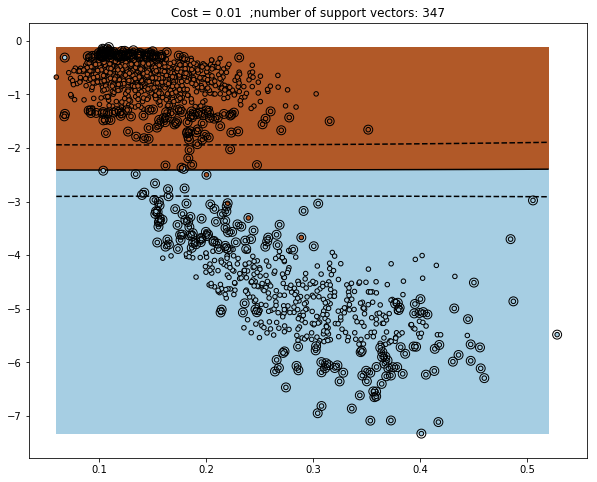

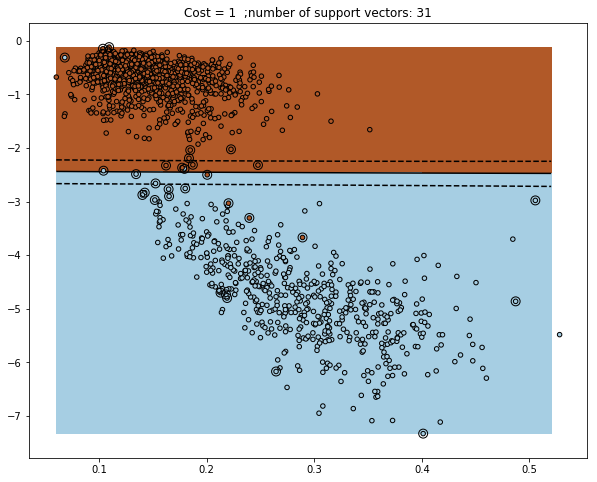

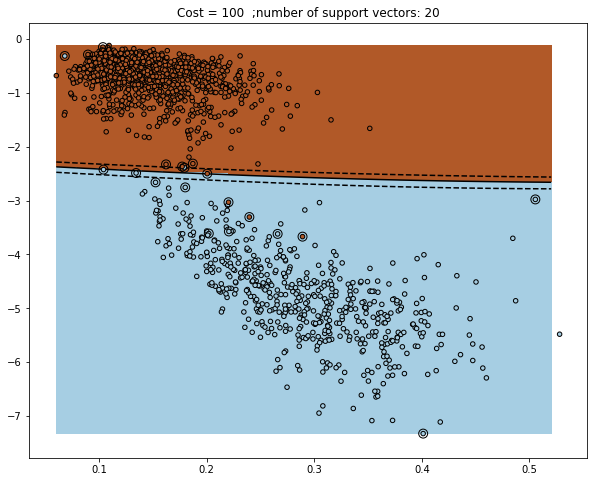

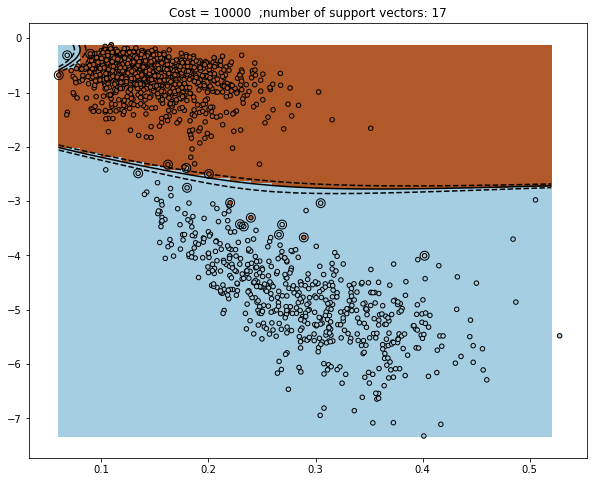

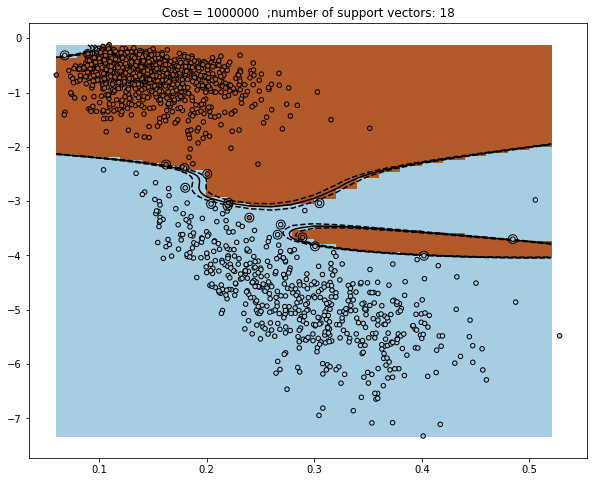

In [39]:
plotDecisionBoundaryRBFSVM(dataTrain, labelTrain, kernel = "rbf", gamma = 'auto', degree = 2)

## Statement of Individual Work

Please initial (between the square brackets) one of the following statements.

[Dong Shaocong] I, <*A0148008J*>, certify that I have followed the CS 3244 Machine Learning class guidelines for homework assignments.  In particular, I expressly vow that I have followed the Facebook rule in discussing with others in doing the assignment and did not take notes (digital or printed) from the discussions.  
